In [ ]:
# bacend.ai
# !pip install prophet
# !pip install plotnine

# import

In [1]:
import numpy as np 
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import warnings
warnings.filterwarnings('ignore')  
warnings.simplefilter(action = "ignore", category = RuntimeWarning)
import datetime as dt
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
# import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import pandas as pd
from plotnine import *
import io

import statistics as st
%matplotlib inline
import matplotlib.dates as mdates
from pandas import DataFrame
from pandas import to_datetime
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error


import sys
sys.path.append("../Import")
from definitions import crop_list3
# crop_list3 = [
#     ("마늘", "garlic"),
#     ("깻잎", "sesameLeaf"),
#     ("감자", "potato"),
#     ("고구마", "sweetPotato"),
# ]
root_path = "../"
data_path = f"{root_path}data/"
# 마늘
Product = "마늘"
Product_eng = "garlic"
Product = crop_list3[0][0]
Product_eng = crop_list3[0][1]


# Data road

In [2]:
df_raw = pd.read_csv(f'{data_path}Agri_all.csv')
df = df_raw[df_raw['Product'] == Product]
df.head()

,YMD,YM,MD,Product,Price,KRW_USD_EXR,Annual_Call_Rate,item_PPI,item_CPI,Food_Price_Index,Cereals_Price_Index,DayAvg_Temperature,DayDiff_Temperature,DayAvg_RelativeHumidity,DaySum_Rainfall,DayAvg_WindSpeed,DaySum_Sunshine,Warning_Count
0,2005-01-03,200501,103,마늘,20785.714286,1013.00,3.33,49.58,58.27,65.4,60.5,4.400000,12.800000,35.200000,0.000000,2.600000,1.600000,0.000000
1,2005-01-04,200501,104,마늘,20785.714286,1013.00,3.33,49.58,58.27,65.4,60.5,-0.200000,8.800000,26.000000,0.000000,2.800000,2.800000,0.000000
2,2005-01-05,200501,105,마늘,20928.571429,1013.00,3.33,49.58,58.27,65.4,60.5,-1.400000,11.200000,33.400000,0.000000,0.600000,3.200000,0.000000
3,2005-01-06,200501,106,마늘,21071.428571,1013.00,3.33,49.58,58.27,65.4,60.5,2.800000,7.800000,31.200000,1.200000,1.200000,2.600000,0.000000
4,2005-01-07,200501,107,마늘,21071.428571,1013.00,3.33,49.58,58.27,65.4,60.5,2.000000,7.600000,28.400000,0.000000,2.800000,2.800000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15875,2020-12-24,202012,1224,고구마,10258.695652,1180.05,0.70,137.90,96.13,108.6,116.4,3.529412,8.588235,59.117647,0.000000,1.705882,3.529412,0.000000
15876,2020-12-28,202012,1228,고구마,10431.323529,1180.05,0.70,137.90,96.13,108.6,116.4,3.941176,11.941176,80.352941,0.058824,0.411765,3.117647,0.000000
15877,2020-12-29,202012,1229,고구마,10431.323529,1180.05,0.70,137.90,96.13,108.6,116.4,1.590909,9.227273,77.227273,1.272727,1.863636,0.636364,0.772727
15878,2020-12-30,202012,1230,고구마,10460.735294,1180.05,0.70,137.90,96.13,108.6,116.4,-5.500000,6.250000,65.375000,0.291667,3.958333,2.666667,0.833333


# Data Pre-processing

## idx, col

In [3]:
# col
df.rename(columns = {'YMD' : 'ds', 'Price' : 'y'}, inplace=True)
# idx
df = df.reset_index()
df = df.drop(columns='index')
df.head()

,ds,YM,MD,Product,y,KRW_USD_EXR,Annual_Call_Rate,item_PPI,item_CPI,Food_Price_Index,Cereals_Price_Index,DayAvg_Temperature,DayDiff_Temperature,DayAvg_RelativeHumidity,DaySum_Rainfall,DayAvg_WindSpeed,DaySum_Sunshine,Warning_Count
0,2005-01-03,200501,103,마늘,20785.714286,1013.00,3.33,49.58,58.27,65.4,60.5,4.400000,12.800000,35.200000,0.000000,2.600000,1.600000,0.000000
1,2005-01-04,200501,104,마늘,20785.714286,1013.00,3.33,49.58,58.27,65.4,60.5,-0.200000,8.800000,26.000000,0.000000,2.800000,2.800000,0.000000
2,2005-01-05,200501,105,마늘,20928.571429,1013.00,3.33,49.58,58.27,65.4,60.5,-1.400000,11.200000,33.400000,0.000000,0.600000,3.200000,0.000000
3,2005-01-06,200501,106,마늘,21071.428571,1013.00,3.33,49.58,58.27,65.4,60.5,2.800000,7.800000,31.200000,1.200000,1.200000,2.600000,0.000000
4,2005-01-07,200501,107,마늘,21071.428571,1013.00,3.33,49.58,58.27,65.4,60.5,2.000000,7.600000,28.400000,0.000000,2.800000,2.800000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3965,2020-12-24,202012,1224,마늘,53533.333333,1180.05,0.70,102.04,118.17,108.6,116.4,4.818182,9.181818,52.515152,0.000000,2.090909,3.303030,0.363636
3966,2020-12-28,202012,1228,마늘,53533.333333,1180.05,0.70,102.04,118.17,108.6,116.4,4.666667,11.481481,79.518519,0.000000,0.592593,3.222222,0.222222
3967,2020-12-29,202012,1229,마늘,53533.333333,1180.05,0.70,102.04,118.17,108.6,116.4,2.903226,9.741935,76.225806,1.645161,1.612903,0.645161,0.709677
3968,2020-12-30,202012,1230,마늘,53533.333333,1180.05,0.70,102.04,118.17,108.6,116.4,-4.057143,7.228571,60.142857,0.714286,4.057143,1.857143,0.857143


## 날짜를 'ds' 컬럼으로 설정.

In [4]:
start_date = pd.to_datetime('2005-01-01') ## 시작 날짜
end_date = pd.to_datetime('2020-12-31') ## 마지막 날짜
 
dates = pd.date_range(start_date,end_date,freq='D') ## 일단위로 생성
dates = pd.DataFrame(dates)
dates = dates.rename(columns={0 : 'ds'})
dates

,ds
0,2005-01-01
1,2005-01-02
2,2005-01-03
3,2005-01-04
4,2005-01-05
...,...
5839,2020-12-27
5840,2020-12-28
5841,2020-12-29
5842,2020-12-30


In [5]:
df['ds'] = pd.to_datetime(df['ds'])

## EDA

In [6]:
def _fig_plot(df, X, Y):
  ''' Function plots the data. requires to provide dataframe in the
  format of date as ds, observation as y, Preset other variables e.g., axis name
  '''
  df.plot(x = X, y = Y, figsize=Figsize, label = Label)
  plt.xlabel(xAxisLabel, fontsize = 16) # matplotlib.pyplot
  plt.ylabel(yAxisLabel, fontsize = 16)
  plt.legend()
  plt.title(Title, fontsize = 20)
  ax = plt.gca().get_xaxis()

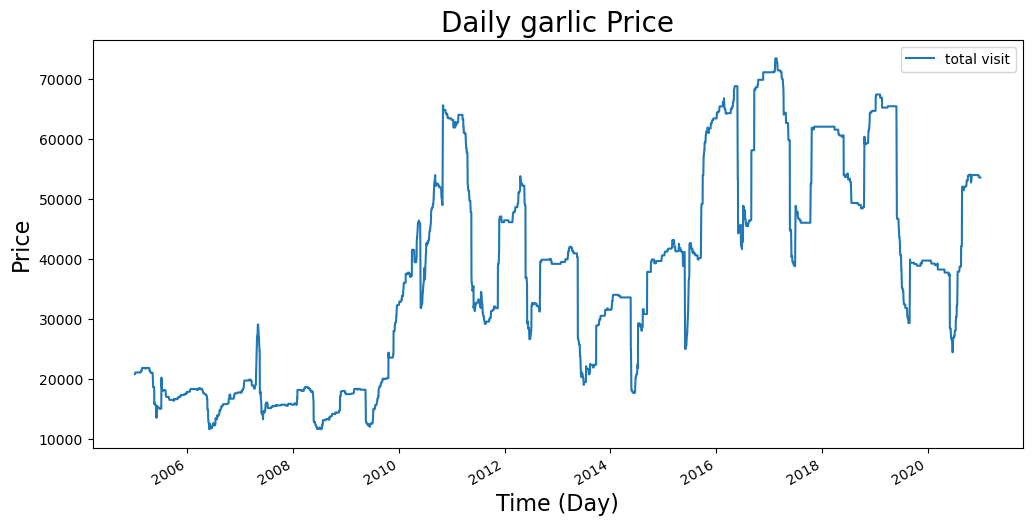

In [7]:
X = 'ds'
Y = 'y'
Label = "total visit"
Figsize = (12,6)
Title = f"Daily {Product_eng} Price"
xAxisLabel = 'Time (Day)'
yAxisLabel = 'Price'
_fig_plot(df, X, Y)

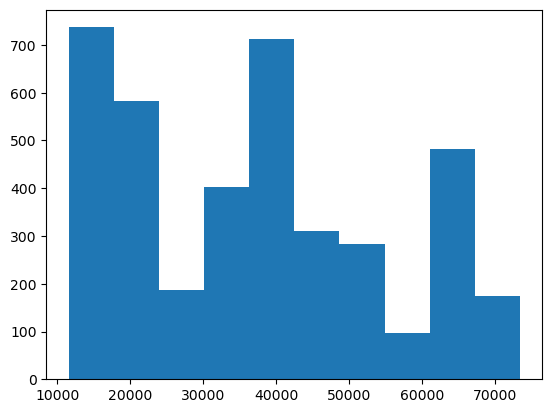

In [8]:
plt.hist(df.y)
plt.show()

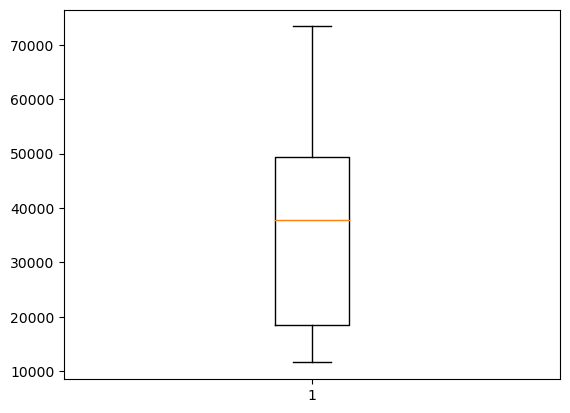

In [9]:
plt.boxplot(df.y)
plt.show()

## df['y'] = np.log(df['y'])

In [10]:
df_raw = df.copy()
df['y'] = np.log(df['y'])

## EDA

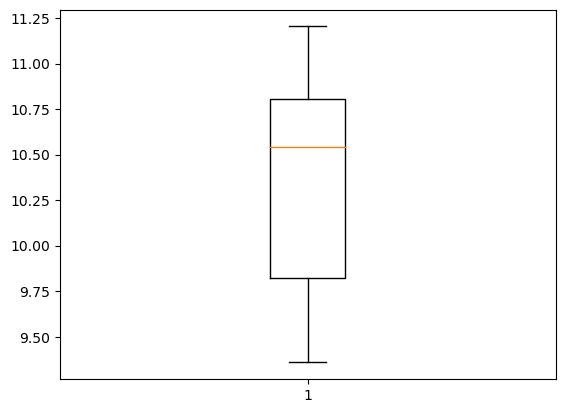

In [11]:
plt.boxplot(df.y.values)
plt.show()

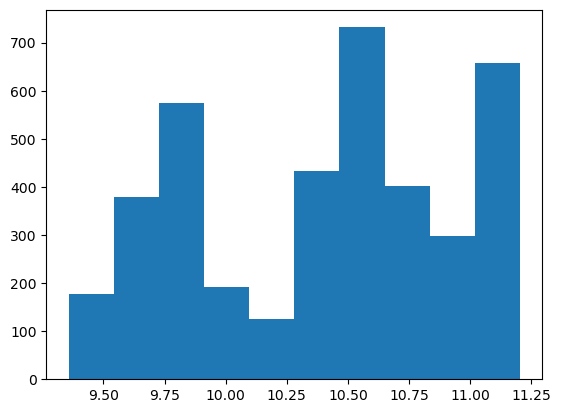

In [12]:
plt.hist(df.y)
plt.show()

## 이상치

In [13]:
Q1=df.y.quantile(0.25)
Q3=df.y.quantile(0.75)
IQR = Q3-Q1
LT=Q1-1.5*IQR
HT= Q3+1.5*IQR
print(LT, HT)
df['outlier']=np.where(((df['y']<LT)|(df['y']>HT)),'yes','no')

8.354394924355471 12.276450021435966


In [14]:
df['outlier'].value_counts()

no    3970
Name: outlier, dtype: int64

## EDA

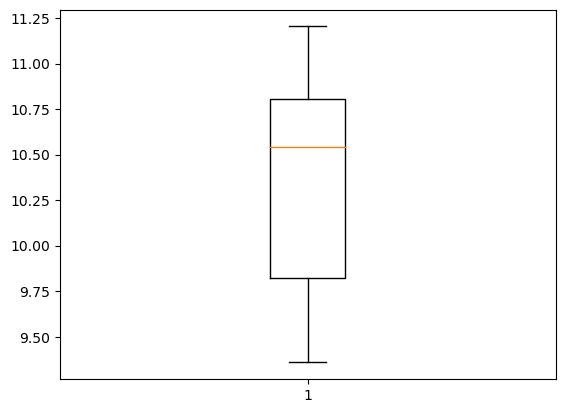

In [15]:
plt.boxplot(df[df.outlier=='no'].y)
plt.show()

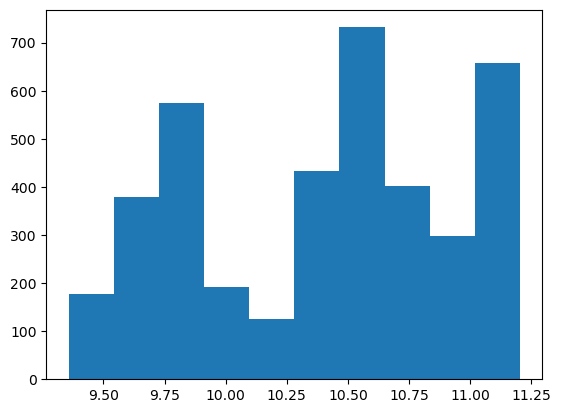

In [16]:
plt.hist(df[df.outlier=='no'].y)
plt.show()

# Modeling

22:16:20 - cmdstanpy - INFO - Chain [1] start processing
22:16:21 - cmdstanpy - INFO - Chain [1] done processing


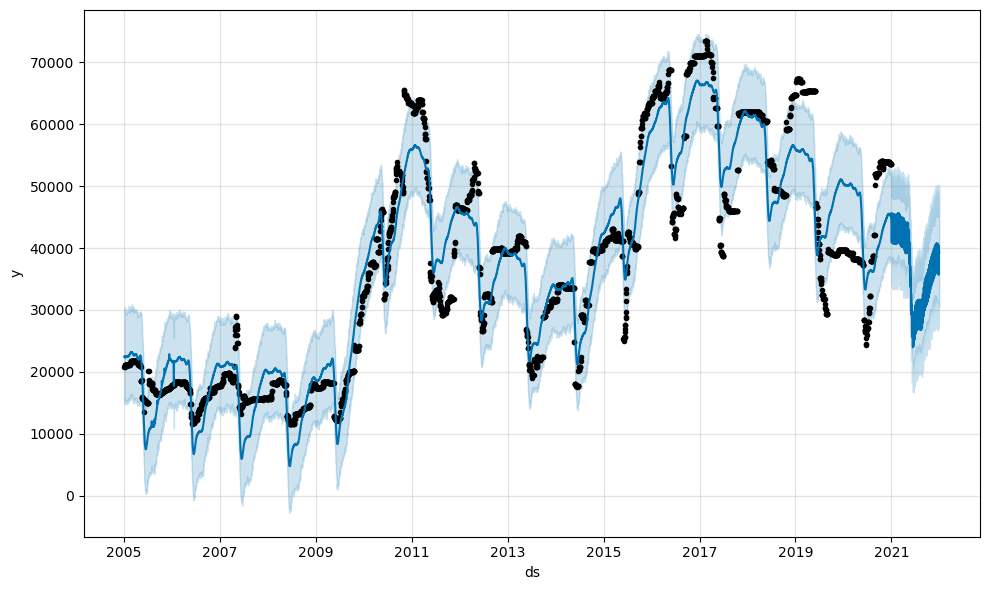

In [17]:
m = Prophet()
m.fit(df_raw)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
fig = m.plot(forecast)
plt.show()

In [18]:
# evaluation_model = cross_validation(m, initial='730 days', period='180 days', horizon = '30 days')
# evaluation_metrix = performance_metrics(evaluation_model)
# evaluation_metrix.head(5)

## data split

In [22]:
index_number = df.index[(df['ds'] == '2019-12-31')][0]
train = df.iloc[:index_number]
test = df.iloc[index_number:]
print('Training data, last date: ' + str(train.tail(1)['ds']) + ' ' + 'testing data, last date: ' + str(test.tail(1)['ds']))

## Parameter - holiday

In [24]:
# 휴일 생성
import holidays

# 필요한 날짜만큼 생성
date_list = pd.date_range('2010-01-01', '2020-12-31')

# 한국 휴일 객체 생성
kr_holidays = holidays.KR()

# generate holiday table
holiday = pd.DataFrame(columns=['ds','holiday'])
holiday['ds'] = sorted(date_list)
holiday['holiday'] = holiday.ds.apply(lambda x: kr_holidays.get(x) if x in kr_holidays else 'non-holiday')
holiday.head()

,ds,holiday
0,2010-01-01,New Year's Day
1,2010-01-02,non-holiday
2,2010-01-03,non-holiday
3,2010-01-04,non-holiday
4,2010-01-05,non-holiday


## Parameter Search - Grid

In [ ]:
from sklearn.model_selection import ParameterGrid
params_grid = {
              'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'holidays_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'n_changepoints' : [100,150,200]
               }
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

In [25]:
model_parameters = pd.DataFrame(columns = ['MAE','Parameters'])
for p in grid:
    LOL = pd.DataFrame()
    print(p)
#    random.seed(0)
    train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                         holidays_prior_scale = p['holidays_prior_scale'],
                         n_changepoints = p['n_changepoints'],
                         seasonality_mode = p['seasonality_mode'],
                         
                         daily_seasonality = True,
                         yearly_seasonality = True,
                         holidays=holiday, 
                         interval_width=0.95)
    
    train_model.fit(train)
    future = train_model.make_future_dataframe(periods=366, freq='D',include_history = False)
    train_forecast = train_model.predict(future)
    LOL=train_forecast[['ds','yhat']]
    y_true= test['y'].values
    y_pred = LOL['yhat'][:len(y_true)].values
    mae = mean_absolute_error(y_true, y_pred)
    print('Mean Absolute Error: %.3f' % mae)
    model_parameters = model_parameters.append({'MAE':mae,'Parameters':p},ignore_index=True)

{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


22:16:23 - cmdstanpy - INFO - Chain [1] start processing
22:16:39 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.394
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


22:16:41 - cmdstanpy - INFO - Chain [1] start processing
22:16:56 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.379
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


22:16:57 - cmdstanpy - INFO - Chain [1] start processing
22:17:20 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.394
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


22:17:21 - cmdstanpy - INFO - Chain [1] start processing
22:17:45 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.380
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


22:17:46 - cmdstanpy - INFO - Chain [1] start processing
22:18:23 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.392
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


22:18:24 - cmdstanpy - INFO - Chain [1] start processing
22:19:06 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.380
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


22:19:07 - cmdstanpy - INFO - Chain [1] start processing
22:19:27 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.393
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


22:19:28 - cmdstanpy - INFO - Chain [1] start processing
22:19:43 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.379
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


22:19:44 - cmdstanpy - INFO - Chain [1] start processing
22:20:14 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.393
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


22:20:15 - cmdstanpy - INFO - Chain [1] start processing
22:20:44 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.378
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


22:20:45 - cmdstanpy - INFO - Chain [1] start processing
22:21:35 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.388
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


22:21:37 - cmdstanpy - INFO - Chain [1] start processing
22:22:20 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.381
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


22:22:22 - cmdstanpy - INFO - Chain [1] start processing
22:22:43 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.393
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


22:22:44 - cmdstanpy - INFO - Chain [1] start processing
22:23:01 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.379
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


22:23:02 - cmdstanpy - INFO - Chain [1] start processing
22:23:30 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.391
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


22:23:31 - cmdstanpy - INFO - Chain [1] start processing
22:23:53 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.381
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


22:23:54 - cmdstanpy - INFO - Chain [1] start processing
22:24:30 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.391
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


22:24:31 - cmdstanpy - INFO - Chain [1] start processing
22:25:16 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.381
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


22:25:17 - cmdstanpy - INFO - Chain [1] start processing
22:25:36 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.395
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


22:25:38 - cmdstanpy - INFO - Chain [1] start processing
22:25:54 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.379
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


22:25:55 - cmdstanpy - INFO - Chain [1] start processing
22:26:23 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.391
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


22:26:25 - cmdstanpy - INFO - Chain [1] start processing
22:26:58 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.379
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


22:27:00 - cmdstanpy - INFO - Chain [1] start processing
22:27:50 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.392
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


22:27:52 - cmdstanpy - INFO - Chain [1] start processing
22:28:37 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.380
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


22:28:38 - cmdstanpy - INFO - Chain [1] start processing
22:28:59 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.391
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


22:29:01 - cmdstanpy - INFO - Chain [1] start processing
22:29:21 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.380
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


22:29:22 - cmdstanpy - INFO - Chain [1] start processing
22:29:59 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.392
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


22:30:00 - cmdstanpy - INFO - Chain [1] start processing
22:30:34 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.380
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


22:30:35 - cmdstanpy - INFO - Chain [1] start processing
22:31:23 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.392
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


22:31:25 - cmdstanpy - INFO - Chain [1] start processing
22:32:09 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.380
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


22:32:10 - cmdstanpy - INFO - Chain [1] start processing
22:32:32 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.394
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


22:32:34 - cmdstanpy - INFO - Chain [1] start processing
22:32:53 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.385
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


22:32:54 - cmdstanpy - INFO - Chain [1] start processing
22:33:31 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.393
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


22:33:32 - cmdstanpy - INFO - Chain [1] start processing
22:34:04 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.389
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


22:34:05 - cmdstanpy - INFO - Chain [1] start processing
22:35:00 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.395
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


22:35:01 - cmdstanpy - INFO - Chain [1] start processing
22:35:50 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.389
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


22:35:52 - cmdstanpy - INFO - Chain [1] start processing
22:36:10 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.395
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


22:36:11 - cmdstanpy - INFO - Chain [1] start processing
22:36:32 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.384
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


22:36:34 - cmdstanpy - INFO - Chain [1] start processing
22:37:09 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.393
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


22:37:11 - cmdstanpy - INFO - Chain [1] start processing
22:37:38 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.382
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


22:37:40 - cmdstanpy - INFO - Chain [1] start processing
22:38:43 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.394
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


22:38:45 - cmdstanpy - INFO - Chain [1] start processing
22:39:22 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.391
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


22:39:23 - cmdstanpy - INFO - Chain [1] start processing
22:39:40 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.394
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


22:39:41 - cmdstanpy - INFO - Chain [1] start processing
22:39:57 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.387
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


22:39:58 - cmdstanpy - INFO - Chain [1] start processing
22:40:26 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.395
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


22:40:27 - cmdstanpy - INFO - Chain [1] start processing
22:40:54 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.385
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


22:40:55 - cmdstanpy - INFO - Chain [1] start processing
22:41:52 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.394
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


22:41:54 - cmdstanpy - INFO - Chain [1] start processing
22:43:12 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.387
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


22:43:14 - cmdstanpy - INFO - Chain [1] start processing
22:44:05 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.395
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


22:44:07 - cmdstanpy - INFO - Chain [1] start processing
22:44:58 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.386
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


22:45:00 - cmdstanpy - INFO - Chain [1] start processing
22:46:09 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.391
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


22:46:10 - cmdstanpy - INFO - Chain [1] start processing
22:46:41 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.389
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


22:46:42 - cmdstanpy - INFO - Chain [1] start processing
22:47:20 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.394
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


22:47:21 - cmdstanpy - INFO - Chain [1] start processing
22:48:05 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.385
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


22:48:07 - cmdstanpy - INFO - Chain [1] start processing
22:48:24 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.397
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


22:48:26 - cmdstanpy - INFO - Chain [1] start processing
22:48:47 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.389
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


22:48:48 - cmdstanpy - INFO - Chain [1] start processing
22:49:13 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.394
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


22:49:15 - cmdstanpy - INFO - Chain [1] start processing
22:49:43 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.388
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


22:49:44 - cmdstanpy - INFO - Chain [1] start processing
22:50:27 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.395
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


22:50:29 - cmdstanpy - INFO - Chain [1] start processing
22:51:48 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.390
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


22:51:49 - cmdstanpy - INFO - Chain [1] start processing
22:52:31 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.396
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


22:52:33 - cmdstanpy - INFO - Chain [1] start processing
22:53:06 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.389
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


22:53:08 - cmdstanpy - INFO - Chain [1] start processing
22:54:00 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.396
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


22:54:01 - cmdstanpy - INFO - Chain [1] start processing
22:54:55 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.390
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


22:54:57 - cmdstanpy - INFO - Chain [1] start processing
22:55:59 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.393
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


22:56:01 - cmdstanpy - INFO - Chain [1] start processing
22:57:06 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.386
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


22:57:07 - cmdstanpy - INFO - Chain [1] start processing
22:57:36 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.395
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


22:57:37 - cmdstanpy - INFO - Chain [1] start processing
22:58:03 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.390
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


22:58:05 - cmdstanpy - INFO - Chain [1] start processing
22:58:51 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.393
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


22:58:53 - cmdstanpy - INFO - Chain [1] start processing
22:59:34 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.387
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


22:59:36 - cmdstanpy - INFO - Chain [1] start processing
23:00:23 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.392
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


23:00:24 - cmdstanpy - INFO - Chain [1] start processing
23:01:09 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.385
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


23:01:10 - cmdstanpy - INFO - Chain [1] start processing
23:01:37 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.395
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


23:01:39 - cmdstanpy - INFO - Chain [1] start processing
23:01:59 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.382
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


23:02:00 - cmdstanpy - INFO - Chain [1] start processing
23:02:32 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.395
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


23:02:33 - cmdstanpy - INFO - Chain [1] start processing
23:03:10 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.387
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


23:03:12 - cmdstanpy - INFO - Chain [1] start processing
23:03:56 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.397
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


23:03:57 - cmdstanpy - INFO - Chain [1] start processing
23:04:39 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.389
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


23:04:40 - cmdstanpy - INFO - Chain [1] start processing
23:05:02 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.396
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


23:05:03 - cmdstanpy - INFO - Chain [1] start processing
23:05:23 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.388
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


23:05:25 - cmdstanpy - INFO - Chain [1] start processing
23:06:03 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.394
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


23:06:04 - cmdstanpy - INFO - Chain [1] start processing
23:06:35 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.388
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


23:06:37 - cmdstanpy - INFO - Chain [1] start processing
23:07:20 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.394
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


23:07:22 - cmdstanpy - INFO - Chain [1] start processing
23:08:00 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.390
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


23:08:01 - cmdstanpy - INFO - Chain [1] start processing
23:08:25 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.396
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


23:08:26 - cmdstanpy - INFO - Chain [1] start processing
23:08:49 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.389
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


23:08:50 - cmdstanpy - INFO - Chain [1] start processing
23:09:30 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.393
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


23:09:32 - cmdstanpy - INFO - Chain [1] start processing
23:10:05 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.390
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


23:10:06 - cmdstanpy - INFO - Chain [1] start processing
23:10:48 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.394
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


23:10:50 - cmdstanpy - INFO - Chain [1] start processing
23:11:33 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.388
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


23:11:35 - cmdstanpy - INFO - Chain [1] start processing
23:12:06 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.396
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


23:12:07 - cmdstanpy - INFO - Chain [1] start processing
23:12:32 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.388
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


23:12:34 - cmdstanpy - INFO - Chain [1] start processing
23:13:15 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.394
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


23:13:17 - cmdstanpy - INFO - Chain [1] start processing
23:13:50 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.386
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


23:13:51 - cmdstanpy - INFO - Chain [1] start processing
23:14:35 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.394
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


23:14:37 - cmdstanpy - INFO - Chain [1] start processing
23:15:23 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.397
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


23:15:24 - cmdstanpy - INFO - Chain [1] start processing
23:15:42 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.396
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


23:15:43 - cmdstanpy - INFO - Chain [1] start processing
23:16:00 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.393
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


23:16:02 - cmdstanpy - INFO - Chain [1] start processing
23:16:31 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.394
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


23:16:33 - cmdstanpy - INFO - Chain [1] start processing
23:17:00 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.394
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


23:17:02 - cmdstanpy - INFO - Chain [1] start processing
23:17:43 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.394
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


23:17:44 - cmdstanpy - INFO - Chain [1] start processing
23:18:25 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.391
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


23:18:26 - cmdstanpy - INFO - Chain [1] start processing
23:18:43 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.395
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


23:18:44 - cmdstanpy - INFO - Chain [1] start processing
23:18:59 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.391
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


23:19:01 - cmdstanpy - INFO - Chain [1] start processing
23:19:28 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.396
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


23:19:29 - cmdstanpy - INFO - Chain [1] start processing
23:19:57 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.393
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


23:19:59 - cmdstanpy - INFO - Chain [1] start processing
23:20:42 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.392
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


23:20:43 - cmdstanpy - INFO - Chain [1] start processing
23:21:17 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.392
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


23:21:18 - cmdstanpy - INFO - Chain [1] start processing
23:21:35 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.393
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


23:21:36 - cmdstanpy - INFO - Chain [1] start processing
23:21:49 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.385
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


23:21:50 - cmdstanpy - INFO - Chain [1] start processing
23:22:17 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.394
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


23:22:19 - cmdstanpy - INFO - Chain [1] start processing
23:22:41 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.387
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


23:22:43 - cmdstanpy - INFO - Chain [1] start processing
23:23:23 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.390
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


23:23:24 - cmdstanpy - INFO - Chain [1] start processing
23:23:56 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.391
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


23:23:57 - cmdstanpy - INFO - Chain [1] start processing
23:24:16 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.396
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


23:24:18 - cmdstanpy - INFO - Chain [1] start processing
23:24:34 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.393
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


23:24:36 - cmdstanpy - INFO - Chain [1] start processing
23:25:03 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.394
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


23:25:04 - cmdstanpy - INFO - Chain [1] start processing
23:25:27 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.389
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


23:25:29 - cmdstanpy - INFO - Chain [1] start processing
23:26:08 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.390
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


23:26:09 - cmdstanpy - INFO - Chain [1] start processing
23:26:46 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.393
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


23:26:47 - cmdstanpy - INFO - Chain [1] start processing
23:27:05 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.395
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


23:27:06 - cmdstanpy - INFO - Chain [1] start processing
23:27:22 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.389
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


23:27:23 - cmdstanpy - INFO - Chain [1] start processing
23:27:49 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.394
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


23:27:50 - cmdstanpy - INFO - Chain [1] start processing
23:28:17 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.391
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


23:28:18 - cmdstanpy - INFO - Chain [1] start processing
23:28:58 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.388
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


23:28:59 - cmdstanpy - INFO - Chain [1] start processing
23:29:38 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.395
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


23:29:39 - cmdstanpy - INFO - Chain [1] start processing
23:29:57 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.393
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


23:29:59 - cmdstanpy - INFO - Chain [1] start processing
23:30:16 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.392
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


23:30:17 - cmdstanpy - INFO - Chain [1] start processing
23:30:47 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.395
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


23:30:48 - cmdstanpy - INFO - Chain [1] start processing
23:31:14 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.391
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


23:31:15 - cmdstanpy - INFO - Chain [1] start processing
23:31:55 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.395
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


23:31:57 - cmdstanpy - INFO - Chain [1] start processing
23:32:35 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.396
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


23:32:36 - cmdstanpy - INFO - Chain [1] start processing
23:32:54 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.397
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


23:32:56 - cmdstanpy - INFO - Chain [1] start processing
23:33:14 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.389
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


23:33:15 - cmdstanpy - INFO - Chain [1] start processing
23:33:44 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.396
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


23:33:45 - cmdstanpy - INFO - Chain [1] start processing
23:34:15 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.397
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


23:34:16 - cmdstanpy - INFO - Chain [1] start processing
23:35:00 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.396
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


23:35:02 - cmdstanpy - INFO - Chain [1] start processing
23:35:44 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.393
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


23:35:45 - cmdstanpy - INFO - Chain [1] start processing
23:36:03 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.395
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


23:36:04 - cmdstanpy - INFO - Chain [1] start processing
23:36:24 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.395
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


23:36:25 - cmdstanpy - INFO - Chain [1] start processing
23:36:56 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.397
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


23:36:58 - cmdstanpy - INFO - Chain [1] start processing
23:37:26 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.387
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


23:37:27 - cmdstanpy - INFO - Chain [1] start processing
23:38:06 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.394
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


23:38:07 - cmdstanpy - INFO - Chain [1] start processing
23:38:44 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.391
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


23:38:45 - cmdstanpy - INFO - Chain [1] start processing
23:39:04 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.395
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


23:39:05 - cmdstanpy - INFO - Chain [1] start processing
23:39:20 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.396
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


23:39:22 - cmdstanpy - INFO - Chain [1] start processing
23:39:52 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.397
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


23:39:53 - cmdstanpy - INFO - Chain [1] start processing
23:40:19 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.396
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


23:40:20 - cmdstanpy - INFO - Chain [1] start processing
23:41:01 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.390
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


23:41:03 - cmdstanpy - INFO - Chain [1] start processing
23:41:40 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 0.393


## Parameters

In [26]:
parameters = model_parameters.sort_values(by=['MAE'])
parameters = parameters.reset_index(drop=True)
parameters.head()

,MAE,Parameters
0,0.378018,"{'changepoint_prior_scale': 0.1, 'holidays_pri..."
1,0.379069,"{'changepoint_prior_scale': 0.1, 'holidays_pri..."
2,0.379079,"{'changepoint_prior_scale': 0.1, 'holidays_pri..."
3,0.379132,"{'changepoint_prior_scale': 0.1, 'holidays_pri..."
4,0.379134,"{'changepoint_prior_scale': 0.1, 'holidays_pri..."


In [27]:
prams = dict(parameters['Parameters'][0])
prams["changepoint_prior_scale"]

0.1

In [28]:
train = train.drop(columns=['YM', 'MD', 'Product', 'KRW_USD_EXR', 'Annual_Call_Rate',
       'item_PPI', 'item_CPI', 'Food_Price_Index', 'Cereals_Price_Index', 'outlier'
       ])
train['Warning_Count'] = np.exp(train['Warning_Count'])
train.columns

Index(['ds', 'y', 'DayAvg_Temperature', 'DayDiff_Temperature',
       'DayAvg_RelativeHumidity', 'DaySum_Rainfall', 'DayAvg_WindSpeed',
       'DaySum_Sunshine', 'Warning_Count'],
      dtype='object')

In [29]:
df = pd.merge(dates, df, how='outer', on='ds')
df

,ds,YM,MD,Product,y,KRW_USD_EXR,Annual_Call_Rate,item_PPI,item_CPI,Food_Price_Index,Cereals_Price_Index,DayAvg_Temperature,DayDiff_Temperature,DayAvg_RelativeHumidity,DaySum_Rainfall,DayAvg_WindSpeed,DaySum_Sunshine,Warning_Count,outlier
0,2005-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2005-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2005-01-03,200501.0,103.0,마늘,9.942021,1013.00,3.33,49.58,58.27,65.4,60.5,4.400000,12.800000,35.200000,0.000000,2.600000,1.600000,0.000000,no
3,2005-01-04,200501.0,104.0,마늘,9.942021,1013.00,3.33,49.58,58.27,65.4,60.5,-0.200000,8.800000,26.000000,0.000000,2.800000,2.800000,0.000000,no
4,2005-01-05,200501.0,105.0,마늘,9.948871,1013.00,3.33,49.58,58.27,65.4,60.5,-1.400000,11.200000,33.400000,0.000000,0.600000,3.200000,0.000000,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5839,2020-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5840,2020-12-28,202012.0,1228.0,마늘,10.888060,1180.05,0.70,102.04,118.17,108.6,116.4,4.666667,11.481481,79.518519,0.000000,0.592593,3.222222,0.222222,no
5841,2020-12-29,202012.0,1229.0,마늘,10.888060,1180.05,0.70,102.04,118.17,108.6,116.4,2.903226,9.741935,76.225806,1.645161,1.612903,0.645161,0.709677,no
5842,2020-12-30,202012.0,1230.0,마늘,10.888060,1180.05,0.70,102.04,118.17,108.6,116.4,-4.057143,7.228571,60.142857,0.714286,4.057143,1.857143,0.857143,no


In [30]:
final_model = Prophet(holidays=holiday,
                      changepoint_prior_scale= prams["changepoint_prior_scale"],
                      holidays_prior_scale = prams["holidays_prior_scale"],
                      n_changepoints = prams["n_changepoints"],
                      seasonality_mode = prams["seasonality_mode"],
                      weekly_seasonality=True,
                      daily_seasonality = True,
                      yearly_seasonality = True,
                      interval_width=0.95)
final_model.fit(train)

23:41:41 - cmdstanpy - INFO - Chain [1] start processing
23:42:08 - cmdstanpy - INFO - Chain [1] done processing


In [31]:
future = final_model.make_future_dataframe(periods=366, freq='D')
forecast = final_model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
4080,2020-12-24,10.719734,10.042560,11.433511
4081,2020-12-25,10.770439,10.112439,11.518382
4082,2020-12-26,10.722062,10.021279,11.481487
4083,2020-12-27,10.702785,10.001087,11.458014
4084,2020-12-28,10.722524,10.026945,11.485598
4085,2020-12-29,10.722507,10.019438,11.467696
4086,2020-12-30,10.725328,10.043569,11.487659


### 주석풀지마시오

In [32]:
# figure = plt.figure(figsize=(12, 6), dpi=80)
# plt.plot(y_true, label='Actual')
# plt.plot(y_pred, label='Predicted')
# plt.xlabel('Time ->>>', fontsize = 18)
# plt.ylabel('$ Price ->>>', fontsize = 18)
# plt.title('Stock price prediction with Fb Prophet', fontsize = 26)
# plt.legend()
# plt.show()

In [33]:
df['y']=np.exp(df['y'])
forecast['yhat']=np.exp(forecast['yhat'])

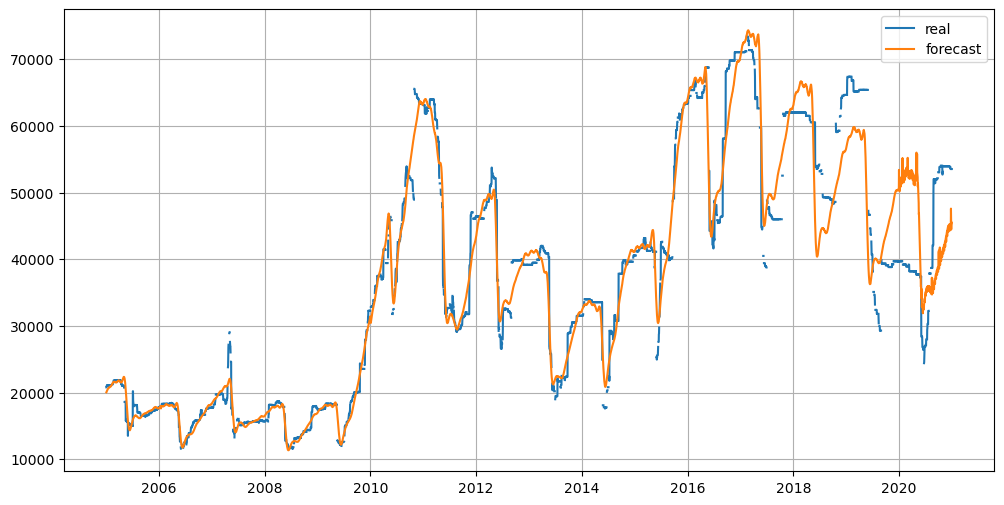

In [34]:
plt.figure(figsize=(12,6))
plt.plot(df['ds'], df['y'], label='real')
plt.plot(forecast['ds'], forecast['yhat'], label='forecast')
plt.grid()
plt.legend()
plt.show()

In [35]:
con = pd.concat([df, forecast], axis=1)
con = con.dropna(axis=0)
df1 = con[df.columns]
forecast1 = con[forecast.columns]

In [36]:
y_true= df1['y'].values
y_pred = forecast1['yhat'].values
mae = mean_absolute_error(y_true, y_pred)
print('Mean Absolute Error: %.3f' % mae)

Mean Absolute Error: 14809.471


In [37]:
evaluation_model = cross_validation(final_model, initial='720 days', period='180 days', horizon = '30 days')
evaluation_metrix = performance_metrics(evaluation_model)
evaluation_metrix.sort_values('mae').head(5)

  0%|          | 0/27 [00:00<?, ?it/s]

23:42:11 - cmdstanpy - INFO - Chain [1] start processing
23:42:13 - cmdstanpy - INFO - Chain [1] done processing
23:42:14 - cmdstanpy - INFO - Chain [1] start processing
23:42:16 - cmdstanpy - INFO - Chain [1] done processing
23:42:17 - cmdstanpy - INFO - Chain [1] start processing
23:42:20 - cmdstanpy - INFO - Chain [1] done processing
23:42:21 - cmdstanpy - INFO - Chain [1] start processing
23:42:24 - cmdstanpy - INFO - Chain [1] done processing
23:42:25 - cmdstanpy - INFO - Chain [1] start processing
23:42:29 - cmdstanpy - INFO - Chain [1] done processing
23:42:30 - cmdstanpy - INFO - Chain [1] start processing
23:42:34 - cmdstanpy - INFO - Chain [1] done processing
23:42:35 - cmdstanpy - INFO - Chain [1] start processing
23:42:40 - cmdstanpy - INFO - Chain [1] done processing
23:42:41 - cmdstanpy - INFO - Chain [1] start processing
23:42:46 - cmdstanpy - INFO - Chain [1] done processing
23:42:47 - cmdstanpy - INFO - Chain [1] start processing
23:42:53 - cmdstanpy - INFO - Chain [1]

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,0.020559,0.143385,0.112591,0.010719,0.007648,0.010696,0.490909
1,4 days,0.023561,0.153497,0.122076,0.011620,0.009189,0.011585,0.463158
2,5 days,0.027274,0.165150,0.132499,0.012630,0.009651,0.012575,0.427751
6,9 days,0.029039,0.170409,0.132897,0.012655,0.009876,0.012653,0.434343
5,8 days,0.031068,0.176263,0.135517,0.012924,0.009665,0.012904,0.487701


In [38]:
con

,ds,YM,MD,Product,y,KRW_USD_EXR,Annual_Call_Rate,item_PPI,item_CPI,Food_Price_Index,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2,2005-01-03,200501.0,103.0,마늘,20785.714286,1013.0,3.33,49.58,58.270,65.4,...,0.002809,0.002809,0.002809,0.112508,0.112508,0.112508,0.0,0.0,0.0,20151.053502
3,2005-01-04,200501.0,104.0,마늘,20785.714286,1013.0,3.33,49.58,58.270,65.4,...,0.002800,0.002800,0.002800,0.114783,0.114783,0.114783,0.0,0.0,0.0,20200.502782
4,2005-01-05,200501.0,105.0,마늘,20928.571429,1013.0,3.33,49.58,58.270,65.4,...,0.002969,0.002969,0.002969,0.117066,0.117066,0.117066,0.0,0.0,0.0,20253.852734
5,2005-01-06,200501.0,106.0,마늘,21071.428571,1013.0,3.33,49.58,58.270,65.4,...,0.002485,0.002485,0.002485,0.123721,0.123721,0.123721,0.0,0.0,0.0,20390.543789
6,2005-01-07,200501.0,107.0,마늘,21071.428571,1013.0,3.33,49.58,58.270,65.4,...,0.001305,0.001305,0.001305,0.125798,0.125798,0.125798,0.0,0.0,0.0,20412.608752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4080,2016-03-04,201603.0,304.0,마늘,64937.500000,1208.5,1.34,132.63,129.497,87.4,...,0.002800,0.002800,0.002800,0.092956,0.092956,0.092956,0.0,0.0,0.0,45239.855062
4083,2016-03-07,201603.0,307.0,마늘,64562.500000,1208.5,1.34,132.63,129.497,87.4,...,-0.016247,-0.016247,-0.016247,0.095945,0.095945,0.095945,0.0,0.0,0.0,44479.574287
4084,2016-03-08,201603.0,308.0,마늘,64187.500000,1208.5,1.34,132.63,129.497,87.4,...,0.002485,0.002485,0.002485,0.097249,0.097249,0.097249,0.0,0.0,0.0,45366.269300
4085,2016-03-09,201603.0,309.0,마늘,64187.500000,1208.5,1.34,132.63,129.497,87.4,...,0.001305,0.001305,0.001305,0.098709,0.098709,0.098709,0.0,0.0,0.0,45365.507161


In [47]:
df_temp = pd.DataFrame()
df_temp["true"] = y_true
df_temp["pred"] = y_pred
df_temp.to_csv(f"{data_path}prophet_garlic_{mae:0.4f}.csv")
print(f"{data_path}prophet_garlic_{mae:0.4f}.csv")
df_temp.head()

../data/prophet_garlic_14809.4705.csv


,true,pred
0,20785.714286,20151.053502
1,20785.714286,20200.502782
2,20928.571429,20253.852734
3,21071.428571,20390.543789
4,21071.428571,20412.608752
